In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
%%capture
!pip install colorama
!cp /content/drive/MyDrive/DataCompetition/TECHNOPRO/dataset/train.zip .
!cp /content/drive/MyDrive/DataCompetition/TECHNOPRO/dataset/test.zip .
!unzip train.zip
!unzip test.zip

## Import

In [ ]:
!pip install grad-cam
!pip install timm
!pip install pytorch_optimizer

import ttach as tta

import os, shutil

#必要なライブラリのインポート
import re, gc, sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from glob import glob

import warnings, random
import cv2

warnings.filterwarnings("ignore")

from sklearn.metrics import accuracy_score, roc_auc_score
from sklearn.model_selection import StratifiedKFold

import timm

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from torch.optim import lr_scheduler
from pytorch_optimizer import Ranger21

import torchvision
from torchvision import transforms
import torchvision.models as models
from torch.cuda.amp import GradScaler

from pytorch_grad_cam import GradCAM, HiResCAM, ScoreCAM, GradCAMPlusPlus, AblationCAM, XGradCAM, EigenCAM, FullGrad
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
from pytorch_grad_cam.utils.image import show_cam_on_image

import yaml
from tqdm import tqdm
import time
import copy
from collections import defaultdict

from colorama import Fore, Back, Style
b_ = Fore.BLUE
y_ = Fore.YELLOW
sr_ = Style.RESET_ALL

## パラメータの設定

In [ ]:
ARGS = {'DATA_DIR': '/content/drive/MyDrive/DataCompetition/TECHNOPRO/dataset',
  # 'OUT_DIR': '/content/drive/MyDrive/DataCompetition/TECHNOPRO/Vit',
  'OUT_DIR': '/content/drive/MyDrive/DataCompetition/TECHNOPRO/Swin',
  # 'OUT_DIR': '/content/drive/MyDrive/DataCompetition/TECHNOPRO/eva02',
  'model_name': 'vit_l_16',
  'n_fold': 5,
  'epochs': 4,
  'criterion': 'CrossEntropy',
  'image_size': (384, 384),
  'train_batch_size': 8, # 元は16
  'test_batch_size': 32,
  'seed': 2023,
  'optimizer': 'AdamW',
  'learning_rate': 1e-05,
  'scheduler': 'CosineAnnealingLR',
  'min_lr': 1e-06,
  'T_max': 500,
  'n_accumulate': 1,
  'clip_grad_norm': 'None',
  'apex': True,
  'num_classes': 2,
  'device': torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
  }
ARGS

{'DATA_DIR': '/content/drive/MyDrive/DataCompetition/TECHNOPRO/dataset',
 'OUT_DIR': '/content/drive/MyDrive/DataCompetition/TECHNOPRO/Swin',
 'model_name': 'vit_l_16',
 'n_fold': 5,
 'epochs': 4,
 'criterion': 'CrossEntropy',
 'image_size': (384, 384),
 'train_batch_size': 8,
 'test_batch_size': 32,
 'seed': 2023,
 'optimizer': 'AdamW',
 'learning_rate': 1e-05,
 'scheduler': 'CosineAnnealingLR',
 'min_lr': 1e-06,
 'T_max': 500,
 'n_accumulate': 1,
 'clip_grad_norm': 'None',
 'apex': True,
 'num_classes': 2,
 'device': device(type='cuda', index=0)}

In [ ]:
def get_logger(filename):
    from logging import getLogger, INFO, StreamHandler, FileHandler, Formatter
    logger = getLogger(__name__)
    logger.setLevel(INFO)
    handler2 = FileHandler(filename=f"{filename}.log")
    handler2.setFormatter(Formatter("%(message)s"))
    logger.addHandler(handler2)
    return logger

#再現性を出すために必要な関数となります
def worker_init_fn(worker_id):
    torch.manual_seed(worker_id)
    random.seed(worker_id)
    np.random.seed(worker_id)
    torch.cuda.manual_seed(worker_id)
    os.environ['PYTHONHASHSEED'] = str(worker_id)

def set_seed(seed=42):
    '''Sets the seed of the entire notebook so results are the same every time we run.
    This is for REPRODUCIBILITY.'''
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    # When running on the CuDNN backend, two further options must be set
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    # Set a fixed value for the hash seed
    os.environ['PYTHONHASHSEED'] = str(seed)


LOGGER = get_logger(ARGS['OUT_DIR']+'train')
set_seed(ARGS["seed"])

## Create Folds

In [ ]:
def create_folds(data, num_splits, seed):
    data["kfold"] = -1

    mskf = StratifiedKFold(n_splits=num_splits, shuffle=True, random_state=seed)
    labels = ["label"]
    data_labels = data[labels].values

    for f, (t_, v_) in enumerate(mskf.split(data, data_labels)):
        data.loc[v_, "kfold"] = f

    return data

train = pd.read_csv(f"{ARGS['DATA_DIR']}/train.csv")
train = create_folds(train, num_splits=ARGS["n_fold"], seed=ARGS["seed"])
print("Folds created successfully")

train.head()

Folds created successfully


,image_name,label,kfold
0,0000.png,0,0
1,0001.png,1,3
2,0002.png,1,2
3,0003.png,1,1
4,0004.png,0,0


In [ ]:
train["label"].value_counts()

1    1182
0     994
Name: label, dtype: int64

In [ ]:
train['kfold'].value_counts()

0    436
3    435
2    435
1    435
4    435
Name: kfold, dtype: int64

## 画像の読み込みと前処理

In [ ]:
class CustomDataset(Dataset):
    def __init__(self, df, transform, data_type):
        self.df = df
        self.data_type = data_type
        self.images = []

        if self.data_type == "train":
            self.image_paths = df['image_name']
            self.labels = df['label']
        if self.data_type == "test":
            self.image_paths = df[0]

        self.transform= transform

        # Load images into RAM beforehand
        for image_path in self.image_paths:
            if self.data_type == "train":
                image = cv2.imread(f"/content/train/{image_path}")
            if self.data_type == "test":
                image = cv2.imread(f"/content/test/{image_path}")

            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
            self.images.append(image)

    def __len__(self):
        return len(self.df)

    def __getitem__(self, index: int):
        image = self.images[index]

        image = self.transform(image=image)["image"]

        if self.data_type == "train":
            label = self.labels[index]
            label = torch.tensor(label, dtype=torch.long)
            return image, label

        if self.data_type == "test":
            return image

In [ ]:
import albumentations as albu
from albumentations.pytorch import transforms as AT

# Augumentation用
image_transform = albu.Compose([
    #albu.Resize(ARGS["image_size"][0], ARGS["image_size"][1]),
    albu.RandomResizedCrop(ARGS["image_size"][0], ARGS["image_size"][1]),
    albu.Flip(p=0.5),
    albu.RandomRotate90(p=0.5),
    albu.Blur(blur_limit=7, always_apply=False, p=0.5),
    #albu.RandomBrightnessContrast(p=0.3),
    #albu.RandomGamma(gamma_limit=(85, 115), p=0.3),
    #albu.ShiftScaleRotate(shift_limit=0.1, scale_limit=0.10, rotate_limit=45, p=0.5),
    albu.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
    AT.ToTensorV2()
])

## 学習用関数定義

In [ ]:
def train_one_epoch(model, optimizer, train_loader, device, epoch):
    model.train()
    dataset_size = 0
    running_loss = 0.0
    running_score = []
    running_score_y = []
    scaler = GradScaler(enabled=ARGS["apex"])

    train_loss = []
    bar = tqdm(enumerate(train_loader), total=len(train_loader))
    for step, (images, targets) in bar:
      images = images.to(device)
      targets = targets.to(device)

      batch_size = targets.size(0)
      with torch.cuda.amp.autocast(enabled=ARGS["apex"]):
          outputs = model(images)
          loss = criterion(ARGS, outputs, targets)

      scaler.scale(loss).backward()

      if ARGS["clip_grad_norm"] != "None":
          grad_norm = torch.nn.utils.clip_grad_norm_(model.parameters(), ARGS["clip_grad_norm"])
      else:
          grad_norm = None

      scaler.step(optimizer)
      scaler.update()

      optimizer.zero_grad()

      if scheduler is not None:
          scheduler.step()

      train_loss.append(loss.item())

      running_loss += (loss.item() * batch_size)
      dataset_size += batch_size

      epoch_loss = running_loss / dataset_size

      running_score.append(outputs.detach().cpu().numpy())
      running_score_y.append(targets.detach().cpu().numpy())

      score = get_score(running_score_y, running_score)

      bar.set_postfix(Epoch=epoch, Train_Loss=epoch_loss,
                      Train_Acc=score[0],
                      Train_Auc=score[1],
                      LR=optimizer.param_groups[0]['lr']
                      )
    gc.collect()
    return epoch_loss, score

In [ ]:

@torch.no_grad()
def valid_one_epoch(args, model, optimizer, valid_loader, epoch):
    model.eval()

    dataset_size = 0
    running_loss = 0.0
    preds = []
    valid_targets = []
    softmax = nn.Softmax()

    bar = tqdm(enumerate(valid_loader), total=len(valid_loader))
    for step, (images, targets) in enumerate(valid_loader):
      images = images.to(args["device"])
      targets = targets.to(args["device"])
      batch_size = targets.size(0)
      with torch.no_grad():
        outputs = model(images)
        predict = outputs.softmax(dim=1)
        loss = criterion(args, outputs, targets)

      running_loss += (loss.item() * batch_size)
      dataset_size += batch_size

      epoch_loss = running_loss / dataset_size

      preds.append(predict.detach().cpu().numpy())
      valid_targets.append(targets.detach().cpu().numpy())

      if len(set(np.concatenate(valid_targets))) == 1:
          continue
      score = get_score(valid_targets, preds)

      bar.set_postfix(Epoch=epoch, Valid_Loss=epoch_loss,
                      Valid_Acc=score[0],
                      Valid_Auc=score[1],
                      LR=optimizer.param_groups[0]['lr'])

    return epoch_loss, preds, valid_targets, score


In [ ]:
def one_fold(model, optimizer, schedulerr, device, num_epochs, fold):

    if torch.cuda.is_available():
        print("[INFO] Using GPU: {}\n".format(torch.cuda.get_device_name()))

    start = time.time()
    best_model_wts = copy.deepcopy(model.state_dict())
    best_epoch_score = np.inf
    best_prediction = None

    best_score = -np.inf
    for epoch in range(1, 1+num_epochs):
      train_epoch_loss, train_score = train_one_epoch(model, optimizer,
                                              train_loader=train_loader,
                                              device=device, epoch=epoch)

      train_acc, train_auc = train_score

      val_epoch_loss, predictions, valid_targets, valid_score = valid_one_epoch(ARGS,
                                                                                model,
                                                                                optimizer,
                                                                                valid_loader,
                                                                                epoch=epoch)
      valid_acc, valid_auc = valid_score


      LOGGER.info(f'Epoch {epoch} - avg_train_loss: {train_epoch_loss:.4f}  avg_val_loss: {val_epoch_loss:.4f}')
      LOGGER.info(f'Epoch {epoch} - Train Acc: {train_acc:.4f}  Train Auc: {train_auc:.4f}  Valid Acc: {valid_acc:.4f}  Valid Auc: {valid_auc:.4f}')

      if valid_auc >= best_score:
        best_score = valid_auc

        print(f"{b_}Validation Score Improved ({best_epoch_score} ---> {valid_auc})")
        best_epoch_score = valid_auc
        best_model_wts = copy.deepcopy(model.state_dict())
        # PATH = f"Score-Fold-{fold}.bin"
        PATH = ARGS["OUT_DIR"] + f"/Score-Fold-{fold}.bin"
        torch.save(model.state_dict(), PATH)
        # Save a model file from the current directory
        print(f"Model Saved{sr_}")

        best_prediction = np.concatenate(predictions, axis=0)[:,1]

    end = time.time()
    time_elapsed = end - start

    LOGGER.info('Training complete in {:.0f}h {:.0f}m {:.0f}s'.format(
        time_elapsed // 3600, (time_elapsed % 3600) // 60, (time_elapsed % 3600) % 60))
    LOGGER.info("Best Score: {:.4f}".format(best_epoch_score))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model, best_prediction, valid_targets

## モデルや損失関数、最適化関数等の定義

In [ ]:
def create_model(args):
    model = timm.create_model('swin_large_patch4_window12_384.ms_in22k_ft_in1k', pretrained=True, num_classes=2)
    return model

# def create_model(args):
#     model = timm.create_model('tf_efficientnetv2_m.in21k_ft_in1k', pretrained=True, num_classes=2)
#     return model

# def create_model(args):
#     model = timm.create_model('eva02_base_patch14_224.mim_in22k', pretrained=True, num_classes=2)
#     return model

# def create_model(args):
#     model = models.vit_l_16(weights=models.vision_transformer.ViT_L_16_Weights.IMAGENET1K_SWAG_LINEAR_V1)
#     model.heads[0] = torch.nn.Linear(in_features=model.heads[0].in_features, out_features=args["num_classes"], bias=True)
#     return model

#ViT_B_16_Weights.IMAGENET1K_SWAG_E2E_V1

# def create_model(args):
#     model = models.vit_l_16(weights=models.vision_transformer.ViT_L_16_Weights.IMAGENET1K_SWAG_E2E_V1)
#     model.heads[0] = torch.nn.Linear(in_features=model.heads[0].in_features, out_features=args["num_classes"], bias=True)
#     return model

def criterion(args, outputs, labels, class_weights=None):
    if args['criterion'] == 'CrossEntropy':
      return nn.CrossEntropyLoss(weight=class_weights).to(args["device"])(outputs, labels)
    elif args['criterion'] == "None":
        return None

def fetch_optimizer(optimizer_parameters, lr, betas, optimizer_name="Adam"):
    if optimizer_name == "Adam":
        optimizer = optim.Adam(optimizer_parameters, lr=lr)
    elif optimizer_name == "AdamW":
        optimizer = optim.AdamW(optimizer_parameters, lr=lr, betas=betas)
    return optimizer

def fetch_scheduler(args, train_size, optimizer):

    if args['scheduler'] == 'CosineAnnealingLR':
        scheduler = lr_scheduler.CosineAnnealingLR(optimizer,T_max=args['T_max'],
                                                   eta_min=args['min_lr'])
    elif args['scheduler'] == 'CosineAnnealingWarmRestarts':
        scheduler = lr_scheduler.CosineAnnealingWarmRestarts(optimizer,T_0=args['T_0'],
                                                             eta_min=args['min_lr'])
    elif args['scheduler'] == "None":
        scheduler = None

    return scheduler

def get_score(y_trues, y_preds):

    predict_list, targets_list = np.concatenate(y_preds, axis=0), np.concatenate(y_trues)
    predict_list_proba = predict_list.copy()[:, 1]
    predict_list = predict_list.argmax(axis=1)

    accuracy = accuracy_score(predict_list, targets_list)
    auc_score = roc_auc_score(targets_list, predict_list_proba)

    return (accuracy, auc_score)

def prepare_loaders(args, train, image_transform, fold):
    df_train = train[train.kfold != fold].reset_index(drop=True)
    df_valid = train[train.kfold == fold].reset_index(drop=True)

    train_dataset = CustomDataset(df_train, image_transform, data_type="train")
    valid_dataset = CustomDataset(df_valid, image_transform, data_type="train")

    train_loader = DataLoader(train_dataset, batch_size=args['train_batch_size'],
                              worker_init_fn=worker_init_fn(args["seed"]),
                              num_workers=4,
                              shuffle=True, pin_memory=True, drop_last=True)
    valid_loader = DataLoader(valid_dataset, batch_size=args['test_batch_size'],
                              num_workers=4,
                              shuffle=False, pin_memory=True)

    return train_loader, valid_loader

In [ ]:
train_copy = train.copy()
LOGGER.info(ARGS)
for fold in range(0, ARGS['n_fold']):
    print(f"{y_}====== Fold: {fold} ======{sr_}")
    LOGGER.info(f"========== fold: {fold} training ==========")

    # Create Dataloaders
    train_loader, valid_loader = prepare_loaders(args=ARGS, train=train, image_transform=image_transform, fold=fold)

    model = create_model(ARGS)
    model = model.to(ARGS["device"])

    #損失関数・最適化関数の定義
    optimizer = fetch_optimizer(model.parameters(), optimizer_name=ARGS["optimizer"], lr=ARGS["learning_rate"], betas=(0.9, 0.999))

    scheduler = fetch_scheduler(args=ARGS, train_size=len(train_loader), optimizer=optimizer)

    model, predictions, targets = one_fold(model, optimizer, scheduler, device=ARGS["device"], num_epochs=ARGS["epochs"], fold=fold)

    train_copy.loc[train_copy[train_copy.kfold == fold].index, "oof"] = predictions

    del model, train_loader, valid_loader
    _ = gc.collect()
    torch.cuda.empty_cache()
    print()

scores = roc_auc_score(train_copy["label"].values, train_copy["oof"].values)
LOGGER.info(f"========== CV ==========")
LOGGER.info(f"CV: {scores:.4f}")

INFO:__main__:{'DATA_DIR': '/content/drive/MyDrive/DataCompetition/TECHNOPRO/dataset', 'OUT_DIR': '/content/drive/MyDrive/DataCompetition/TECHNOPRO/Swin', 'model_name': 'vit_l_16', 'n_fold': 5, 'epochs': 4, 'criterion': 'CrossEntropy', 'image_size': (384, 384), 'train_batch_size': 8, 'test_batch_size': 32, 'seed': 2023, 'optimizer': 'AdamW', 'learning_rate': 1e-05, 'scheduler': 'CosineAnnealingLR', 'min_lr': 1e-06, 'T_max': 500, 'n_accumulate': 1, 'clip_grad_norm': 'None', 'apex': True, 'num_classes': 2, 'device': device(type='cuda', index=0)}
INFO:__main__:========== fold: 0 training ==========


====== Fold: 0 ======
[INFO] Using GPU: Tesla T4



  0%|          | 0/14 [00:34<?, ?it/s, Epoch=1, LR=6.43e-6, Valid_Acc=0.72, Valid_Auc=0.772, Valid_Loss=0.567]
INFO:__main__:Epoch 1 - avg_train_loss: 0.6082  avg_val_loss: 0.5666
INFO:__main__:Epoch 1 - Train Acc: 0.6624  Train Auc: 0.7125  Valid Acc: 0.7202  Valid Auc: 0.7715


Validation Score Improved (inf ---> 0.7715370099442359)
Model Saved


  0%|          | 0/14 [00:33<?, ?it/s, Epoch=2, LR=1.38e-6, Valid_Acc=0.739, Valid_Auc=0.82, Valid_Loss=0.507]
INFO:__main__:Epoch 2 - avg_train_loss: 0.4919  avg_val_loss: 0.5068
INFO:__main__:Epoch 2 - Train Acc: 0.7615  Train Auc: 0.8244  Valid Acc: 0.7385  Valid Auc: 0.8199


Validation Score Improved (0.7715370099442359 ---> 0.8199011937323749)
Model Saved


  0%|          | 0/14 [00:33<?, ?it/s, Epoch=3, LR=2.88e-6, Valid_Acc=0.761, Valid_Auc=0.846, Valid_Loss=0.479]
INFO:__main__:Epoch 3 - avg_train_loss: 0.4639  avg_val_loss: 0.4792
INFO:__main__:Epoch 3 - Train Acc: 0.7874  Train Auc: 0.8467  Valid Acc: 0.7615  Valid Auc: 0.8463


Validation Score Improved (0.8199011937323749 ---> 0.8462565994529611)
Model Saved


  0%|          | 0/14 [00:33<?, ?it/s, Epoch=4, LR=8.54e-6, Valid_Acc=0.766, Valid_Auc=0.843, Valid_Loss=0.493]
INFO:__main__:Epoch 4 - avg_train_loss: 0.4402  avg_val_loss: 0.4926
INFO:__main__:Epoch 4 - Train Acc: 0.7886  Train Auc: 0.8595  Valid Acc: 0.7661  Valid Auc: 0.8430
INFO:__main__:Training complete in 0h 12m 50s
INFO:__main__:Best Score: 0.8463
INFO:__main__:========== fold: 1 training ==========



====== Fold: 1 ======
[INFO] Using GPU: Tesla T4



  0%|          | 0/14 [00:05<?, ?it/s, Epoch=1, LR=6.43e-6, Valid_Acc=0.719, Valid_Auc=0.874, Valid_Loss=0.461]

In [ ]:
# OOF
train_copy.to_csv(ARGS['OUT_DIR'] + f'/oof.csv', index=False)

## 結果の表示

In [ ]:
#sample_submit.csvを読み込みます
submit = pd.read_csv(f"{ARGS['DATA_DIR']}/sample_submit.csv", header=None)
submit.head()

## Inference

In [ ]:
# test用のデータ拡張
image_transform_test = albu.Compose([
    albu.Resize(ARGS["image_size"][0], ARGS["image_size"][1]),
    albu.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
    AT.ToTensorV2 ()
    ])
test_dataset = CustomDataset(submit, image_transform_test, data_type="test")
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=4)

In [ ]:
# TTA(Test-Time Augmentation)
transforms = tta.Compose(
    [
        tta.HorizontalFlip(),
        tta.VerticalFlip(),
    ]
)

@torch.no_grad()
def valid_fn(model, dataloader, device):
    model.eval()
    tta_model = tta.ClassificationTTAWrapper(model, transforms)

    dataset_size = 0
    running_loss = 0.0

    predict_list = []

    bar = tqdm(enumerate(dataloader), total=len(dataloader))
    for step, images in bar:
        images = images.to(device)
        with torch.no_grad():
            outputs = tta_model(images)
            #出力にソフトマックス関数を適用
            predicts = outputs.softmax(dim=1)

        predicts = predicts.cpu().detach().numpy()
        predict_list.append(predicts)
    predict_list = np.concatenate(predict_list, axis=0)
    #予測値が1である確率を提出します。
    predict_list = predict_list[:, 1]
    gc.collect()

    return predict_list

In [ ]:
def inference(model_paths, dataloader, device):
    final_preds = []
    for i, path in enumerate(model_paths):
        model = create_model(ARGS)
        model = model.to(device)

        #学習済みモデルの読み込み
        model.load_state_dict(torch.load(path))
        model.eval()

        print(f"Getting predictions for model {i+1}")
        preds = valid_fn(model, dataloader, device)
        final_preds.append(preds)

    final_preds = np.array(final_preds)
    final_preds = np.mean(final_preds, axis=0)
    return final_preds

In [ ]:
MODEL_PATHS = [
    f"{ARGS['OUT_DIR']}/Score-Fold-{i}.bin" for i in range(ARGS["n_fold"])
]

predict_list = inference(MODEL_PATHS, test_loader, ARGS["device"])
submit[1] = predict_list
submit.head()

In [ ]:
submit.to_csv(f"{ARGS['OUT_DIR']}/submission_swin_CV{scores:.4f}.csv", index=False, header=None)

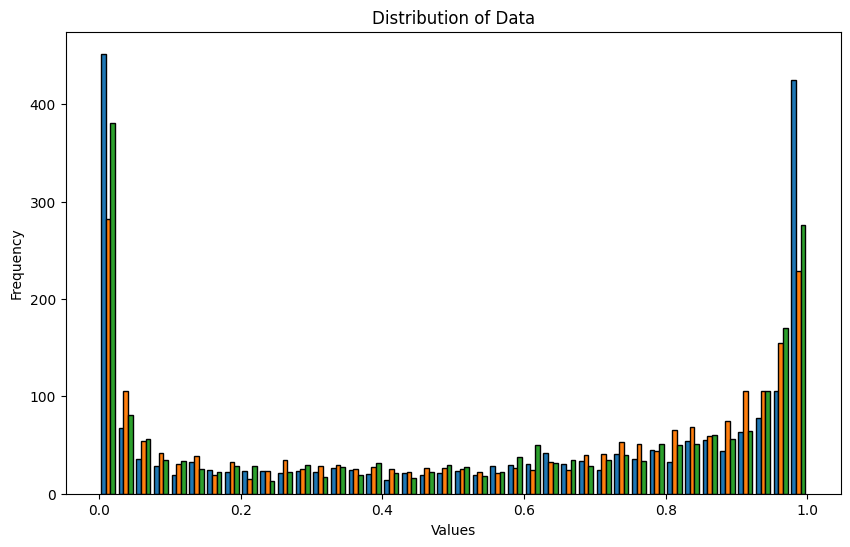

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

vit = pd.read_csv('drive/MyDrive/DataCompetition/TECHNOPRO/submission_vit_CV0.95.csv', names=['id', 'y'])
vit2 = pd.read_csv('drive/MyDrive/DataCompetition/TECHNOPRO/submission_vit_CV0.9267.csv', names=['id', 'y'])
swin = pd.read_csv('drive/MyDrive/DataCompetition/TECHNOPRO/submission_swin_384_CV0.9280.csv', names=['id', 'y'])
swin2 = pd.read_csv('drive/MyDrive/DataCompetition/TECHNOPRO/submission_mix4.csv', names=['id', 'y'])
sample = pd.read_csv('drive/MyDrive/DataCompetition/TECHNOPRO/dataset/sample_submit.csv', names=['id', 'y'])

df = pd.DataFrame()
df['id'] = sample['id']
df['vit'] = vit['y']
df['vit2'] = vit2['y']
df['swin'] = swin['y']
df['swin2'] = swin2['y']
df['mix'] = df['vit']*0.8 + df['swin2']*0.2
plt.figure(figsize=(10, 6))
plt.hist(df[['vit', 'swin', 'mix']], bins=40, edgecolor='black')
plt.xlabel('Values')
plt.ylabel('Frequency')
plt.title('Distribution of Data')
plt.show()
df[['id', 'mix']].to_csv('drive/MyDrive/DataCompetition/TECHNOPRO/submission_vit_mix.csv', header=None, index=None)